# Coding Cubic Spline interpolation from scratch
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Base Data
X = []
Y = [1, 3, 2, 10, 1.65, 2.3, 15, 10, 7.89]
X_interpolate = np.linspace(0, np.max(X), 100)

## Code and math demonstration
___

For each node, there is a cubic function in the form:  
$$ S_i(x) = a_{i}(x - x_{i})^3 + b_{i}(x - x_{i})^2 + c_{i}(x - x_{i}) + d_{i} $$  
Therefore, for a $n$ size dataset, there are $n-1$ equations.  

In order to find each parameters, we have the following conditions:  
(1) $ S_i(x_i) = y_i $ for $1$ to $n-1$  
(2) $ S_{i}(x_{i+1}) = y_{i+1} $ for $1$ to $n-1$   
(3) $ S'_{i}(x_{i+1}) = S'_{i+1}(x_{i+1}) $ for $1$ to $n-2$   
(4) $ S''_{i}(x_{i+1}) = S''_{i+1}(x_{i+1}) $ for $1$ to $n-2$   
(5) $ S''_{1}(x_1) = S''_{n-1}(x_n) = 0 $  
  
We will solve the system using linear algebra, e.g. Matrix multiplication between the equation system matrix and the output vector. 

- Condition (1) gives from $1$ to $n-1$:  
$$ S_i(x_i) = y_i $$
$$ \Leftrightarrow a_i(x_i - x_i)^3 + b_i(x_i - x_i)^2 + c_i(x_i - x_i) + d_i = y_i $$
$$ \Leftrightarrow d_i = y_i $$  

In [3]:
# Generate Condition 1 matrix
def cond_1_matrix(X, Y):
    
    # Initialize the matrix
    # Size is 4(n-1) x (n-1), rows = number of coefficient (4 per equation), rows = number of equation (e.g. number of node)
    n = len(X)
    coef_matrix = np.zeros((n-1, 4*(n-1)))
    
    # Initialize the result vector
    result_vector = []
    
    # Input values according to Condition 1
    for i in range(n-1):
        
        # As d_i is always 1
        coef_matrix[i, 4*(i+1)-1] = 1
        result_vector.append(Y[i])
    
    return coef_matrix, result_vector

- Condition (2) gives from $1$ to $n-1$:  
$$ S_{i}(x_{i+1}) = y_{i+1} $$
$$ \Leftrightarrow a_{i}(x_{i+1} - x_{i})^3 + b_{i}(x_{i+1} - x_{i})^2 + c_{i}(x_{i+1} - x_{i}) + d_{i} = y_{i+1} $$
$$ \Leftrightarrow a_{i}(x_{i+1}^3 - 3x_{i+1}^{2}x_{i} + 3x_{i+1}x_{i}^{2} - x_{i}^{3}) + b_{i}(x_{i+1}^2 - 2x_{i+1}x_{i} + x_{i}^{2}) + c_{i}(x_{i+1} - x_{i}) + d_{i} = y_{i+1} $$

In [4]:
# Generate Condition 2 matrix
def cond_2_matrix(X, Y):
    
    # Initialize the matrix
    # Size is 4(n-1) x (n-1), rows = number of coefficient (4 per equation), rows = number of equation (e.g. number of node)
    n = len(X)
    coef_matrix = np.zeros((n-1, 4*(n-1)))

    # Create the result vector
    result_vector = []
    
    # Input values according to Condition 2
    for i in range(n-1):
        a_x = (X[i+1]**3)  - 3*(X[i+1]**2)*(X[i]) + 3*(X[i+1])*(X[i]**2) - (X[i]**3)
        b_x = (X[i+1]**2) - 2*(X[i+1])*(X[i]) + (X[i]**2)
        c_x = X[i+1] - X[i]
        d_x = 1
            
        coef_matrix[i, 4*(i+1)-4] = a_x
        coef_matrix[i, 4*(i+1)-3] = b_x
        coef_matrix[i, 4*(i+1)-2] = c_x
        coef_matrix[i, 4*(i+1)-1] = d_x
    
        result_vector.append(Y[i+1])
    
    return coef_matrix, result_vector

- Condition (3) gives from $1$ to $n-2$:  
$$ S'_{i}(x_{i+1}) = S'_{i+1}(x_{i+1}) $$
We have:
$$ S_{i}(x_{i+1}) = a_{i}(x_{i+1}^3 - 3x_{i+1}^{2}x_{i} + 3x_{i+1}x_{i}^{2} - x_{i}^{3}) + b_{i}(x_{i+1}^2 - 2x_{i+1}x_{i} + x_{i}^{2}) + c_{i}(x_{i+1} - x_{i}) + d_{i} $$
$$ \Leftrightarrow  S'_{i}(x_{i+1}) = a_{i}(3x_{i+1}^2 - 6x_{i+1}x_{i} + 3x_{i}^{2}) + b_{i}(2x_{i+1} - 2x_{i}) + c_{i} $$
And also (for clarity sake, we make the distinction between $x_{i+1}$ which is not a constant and $x_{i+1}^{[c]}$ the constant):  
$$ S_{i+1}(x_{i+1}) = a_{i+1}(x_{i+1}^3 - 3x_{i+1}^{2}x_{i+1}^{[c]} + 3x_{i+1}x_{i+1}^{[c]2} - x_{i+1}^{[c]3}) + b_{i+1}(x_{i+1}^2 - 2x_{i+1}x_{i+1}^{[c]} + x_{i+1}^{[c]2}) + c_{i+1}(x_{i+1} - x_{i+1}^{[c]}) + d_{i+1} $$
$$ \Leftrightarrow  S'_{i+1}(x_{i+1}) = a_{i+1}(3x_{i+1}^2 - 6x_{i+1}x_{i+1}^{[c]} + 3x_{i+1}^{[c]2}) + b_{i+1}(2x_{i+1} - 2x_{i+1}^{[c]}) + c_{i+1} $$
Given $x_{i+1} = x_{i+1}^{[c]}$, we thus get :
$$ \Leftrightarrow  S'_{i+1}(x_{i+1}) = c_{i+1} $$
As such, we finally obtain:
$$ S'_{i}(x_{i+1}) = S'_{i+1}(x_{i+1}) $$
$$ \Leftrightarrow a_{i}(3x_{i+1}^2 - 6x_{i+1}x_{i} + 3x_{i}^{2}) + b_{i}(2x_{i+1} - 2x_{i}) + c_{i} = c_{i+1} $$
$$ \Leftrightarrow a_{i}(3x_{i+1}^2 - 6x_{i+1}x_{i} + 3x_{i}^{2}) + b_{i}(2x_{i+1} - 2x_{i}) + c_{i} - c_{i+1} = 0 $$

In [5]:
# Generate Condition 3 matrix
def cond_3_matrix(X, Y):
    
    # Initialize the matrix
    # Size is 4(n-1) x (n-2), rows = number of coefficient (4 per equation), rows = number of equation (e.g. number of node)
    n = len(X)
    coef_matrix = np.zeros((n-2, 4*(n-1)))

    # Initialize the result vector
    result_vector = [0] * (n-2)
    
    # Input values according to Condition 3
    for i in range(n-2):
        a_x = 3*(X[i+1]**2)  - 6*(X[i+1])*(X[i]) + 3*(X[i]**2)
        b_x = 2*(X[i+1]) - 2*(X[i])
        c_x = 1
        c_x_sec = -1
        
        coef_matrix[i, 4*i] = a_x
        coef_matrix[i, 4*i + 1] = b_x
        coef_matrix[i, 4*i + 2] = c_x
        coef_matrix[i, 4*i + 6] = c_x_sec
    
    return coef_matrix, result_vector

- Condition (4) gives from $1$ to $n-2$:  
$$ S''_{i}(x_{i+1}) = S''_{i+1}(x_{i+1}) $$
We have:
$$ S'_{i}(x_{i+1}) = a_{i}(3x_{i+1}^2 - 6x_{i+1}x_{i} + 3x_{i}^{2}) + b_{i}(2x_{i+1} - 2x_{i}) + c_{i} $$
$$ \Leftrightarrow  S''_{i}(x_{i+1}) = a_{i}(6x_{i+1} - 6x_{i}) + 2b_{i} $$

And also (for clarity sake, we make the distinction between $x_{i+1}$ which is not a constant and $x_{i+1}^{[c]}$ the constant):  
$$ S'_{i+1}(x_{i+1}) = a_{i+1}(3x_{i+1}^2 - 6x_{i+1}x_{i+1}^{[c]} + 3x_{i+1}^{[c]2}) + b_{i+1}(2x_{i+1} - 2x_{i+1}^{[c]}) + c_{i+1} $$
$$ \Leftrightarrow S''_{i+1}(x_{i+1}) = a_{i+1}(6x_{i+1} - 6x_{i+1}^{[c]}) + 2b_{i+1} $$
Given $x_{i+1} = x_{i+1}^{[c]}$, we thus get :
$$ \Leftrightarrow  S''_{i+1}(x_{i+1}) = 2b_{i+1} $$
As such, we finally obtain:
$$ S''_{i}(x_{i+1}) = S''_{i+1}(x_{i+1}) $$
$$ \Leftrightarrow a_{i}(6x_{i+1} - 6x_{i}) + 2b_{i} = 2b_{i+1} $$
$$ \Leftrightarrow a_{i}(6x_{i+1} - 6x_{i}) + 2b_{i} - 2b_{i+1} = 0 $$

In [6]:
# Generate Condition 4 matrix
def cond_4_matrix(X, Y):
    
    # Initialize the matrix
    # Size is 4(n-1) x (n-2), rows = number of coefficient (4 per equation), rows = number of equation (e.g. number of node)
    n = len(X)
    coef_matrix = np.zeros((n-2, 4*(n-1)))

    # Initialize the result vector
    result_vector = [0] * (n-2)
    
    # Input values according to Condition 4
    for i in range(n-2):
        a_x = 6*(X[i+1]) - 6*(X[i])
        b_x = 2
        b_x_sec = -2
            
        coef_matrix[i, 4*i] = a_x
        coef_matrix[i, 4*i + 1] = b_x
        coef_matrix[i, 4*i + 5] = b_x_sec
    
    return coef_matrix, result_vector

- Condition (5) gives 2 final equations to solve the system:  
$$ S''_1(x_1) = 0 $$
$$ \Leftrightarrow a_{1}(6x_{1} - 6x_{1}) + 2b_{1} = 0 $$
$$ \Leftrightarrow 2b_{1} = 0 $$
And:
$$ S''_{n-1}(x_n) = 0 $$
$$ \Leftrightarrow a_{n-1}(6x_{n} - 6x_{n-1}) + 2b_{n-1} = 0 $$

In [7]:
# Generate Condition 5 matrix
def cond_5_matrix(X, Y):
    
    # Initialize the matrix
    # Size is 4(n-1) x (n-2), rows = number of coefficient (4 per equation), rows = number of equation (e.g. number of node)
    n = len(X)
    coef_matrix = np.zeros((2, 4*(n-1)))

    # Initialize the result vector
    result_vector = [0] * 2
    
    # Input values according to Condition 5
    coef_matrix[0, 1] = 2
    coef_matrix[1, 4*(n-2)] = 6*X[n-1] - 6*X[n-2]
    coef_matrix[1, 4*(n-2)+1] = 2
    
    return coef_matrix, result_vector

In [8]:
def create_spline_matrices(X, Y):
    
    matrix_function = {'Condition_1': cond_1_matrix, 'Condition_2': cond_2_matrix, 'Condition_3': cond_3_matrix, 
                       'Condition_4': cond_4_matrix, 'Condition_5': cond_5_matrix}
    
    coef_matrix = np.array([]) 
    result_vector = []
    
    for i in range(1, 6):
        temp_matrix, temp_vector = matrix_function['Condition_' + str(i)](X, Y)
        
        if i == 1:
            coef_matrix = temp_matrix 
        else:
            coef_matrix = np.concatenate((coef_matrix, temp_matrix))
        
        result_vector += temp_vector
    
    result_vector = np.array(result_vector)
    result_vector = result_vector[:, np.newaxis]
    
    return coef_matrix, result_vector

Let $M$ be the matrix representing the equation system, $A$ be the parameter column vector and $Z$ the output column vector.  
We therefore have: $MA = Z$.  
Thus far, we have created $M$ and $Z$ in order to calculate $A$ which can now be obtained by: $ A = M^{-1}Z $.

In [9]:
# To Do Matrix Inversion Function
def matrix_inversion(input_matrix):
    
    return inverted_matrix

In [10]:
def calculate_parameters(coef_matrix, result_vector):
    
    parameters = np.dot(np.linalg.inv(coef_matrix), result_vector)
    
    return parameters

Once $S_i(x)$ for $1$ to $n-1$ has been found, the interpolation function needs to find the range where the value to interpolate fits, and apply the respective $S_i(x)$.

In [11]:
def Cubic_Spline(t, X, Y):
    
    # Initialization of resulting variables
    all_ranges = {}
    ordered_parameters = {}
    interpolation_result = []
    
    n = len(X)
    
    # Get M, A and Z
    coef_matrix, result_vector = create_spline_matrices(X, Y)
    parameters = calculate_parameters(coef_matrix, result_vector)
    
    
    for i in range(n-1):
        all_ranges[i] = [X[i], X[i+1]]
        ordered_parameters[i] = {'a': parameters[4*(i)][0], 'b': parameters[4*(i)+1][0], 'c': parameters[4*(i)+2][0], 
                                 'd': parameters[4*(i)+3][0]}
    
    for i in range(len(t)):
        if t[i] < all_ranges[0][0]:
            idx = 0
        elif t[i] > all_ranges[n-2][1]:
            idx = n-2
        else:
            for j in range(n-1):
                if (t[i] >= all_ranges[j][0]) & (t[i] <= all_ranges[j][1]):
                    idx = j

        result = (ordered_parameters[idx]['a'] * (t[i] - X[idx])**3 + ordered_parameters[idx]['b'] * (t[i] - X[idx])**2 + 
                  ordered_parameters[idx]['c'] * (t[i] - X[idx]) + ordered_parameters[idx]['d'])
        interpolation_result.append(result)
    
    return interpolation_result, all_ranges, ordered_parameters, parameters

In [12]:
interpolation_result, all_ranges, ordered_parameters, parameters = Cubic_Spline(X_interpolate, X, Y)

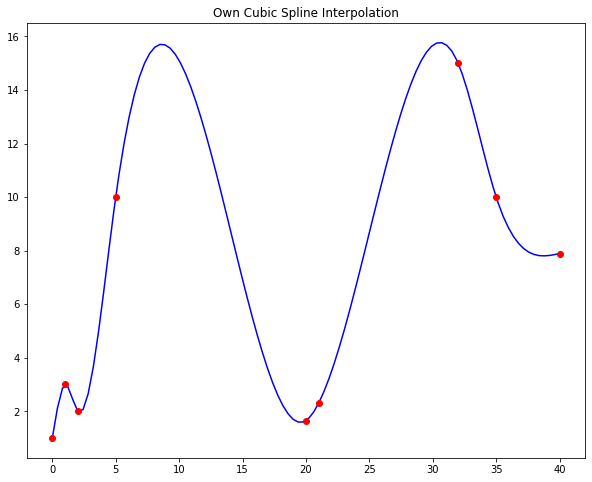

In [13]:
plt.figure(figsize = (10,8))
plt.plot(X_interpolate, interpolation_result, 'b')
plt.plot(X, Y, 'ro')
plt.title('Own Cubic Spline Interpolation')
plt.show()

## Comparing result with Scipy CubicSpline
___

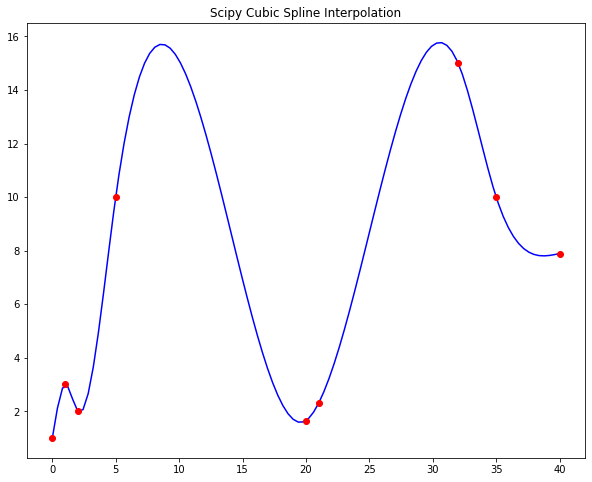

In [14]:
from scipy import interpolate

f = interpolate.CubicSpline(X, Y, bc_type='natural')
scipy_interpolation = f(X_interpolate)

plt.figure(figsize = (10,8))
plt.plot(X_interpolate, scipy_interpolation, 'b')
plt.plot(X, Y, 'ro')
plt.title('Scipy Cubic Spline Interpolation')
plt.show()

In [15]:
round(np.sum(np.subtract(interpolation_result, scipy_interpolation)), 2)

-0.0